<a href="https://colab.research.google.com/github/dclocky/quant_analysis/blob/main/DarynLoughlinQuantProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive,files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install requests pandas pyjstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyjstat: filename=pyjstat-2.4.0-py3-none-any.whl size=22763 sha256=32a19b537491d1055efff70b7fe6c7b3e92a1ecb72250d75f1f41b4bcd50d8f4
  Stored in directory: /root/.cache/pip/wheels/d7/b0/ac/350c026feabb6a22b2a5b3fb1f694e724c0f57c2c43ccaf738
Successfully built pyjstat


##Below is the import for the RPPI - A file I have downloaded from the CSO's website reference : ##

In [ ]:
!unzip /content/gdrive/MyDrive/PPR-ALL.zip

Archive:  /content/gdrive/MyDrive/PPR-ALL.zip
  inflating: PPR-ALL.csv             


In [ ]:
import pandas as pd
encodings_to_try = ['utf-8', 'ISO-8859-1', 'cp1252']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv('/content/PPR-ALL.csv', encoding=encoding)
        break
    except UnicodeDecodeError:
        continue

<ipython-input-5-c42b407f1a8d>:6: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/PPR-ALL.csv', encoding=encoding)


##Cleaning Data for the RRPI dataset above ##


In [ ]:
print(f"Column 8 name: {df.columns[8]}")
print(df.iloc[:, 8].head(20))

Column 8 name: Property Size Description
0                                                   NaN
1     greater than or equal to 38 sq metres and less...
2                                                   NaN
3                                                   NaN
4                                                   NaN
5                                                   NaN
6                                                   NaN
7                                                   NaN
8                                                   NaN
9                                                   NaN
10    greater than or equal to 38 sq metres and less...
11                                                  NaN
12                                                  NaN
13                                                  NaN
14                           greater than 125 sq metres
15                                                  NaN
16                                                  NaN
17     

In [ ]:
df.drop(df.columns[[3, 8]], axis=1, inplace=True)
df.columns

Index(['Date of Sale (dd/mm/yyyy)', 'Address', 'County', 'Price ()',
       'Not Full Market Price', 'VAT Exclusive', 'Description of Property'],
      dtype='object')

In [ ]:
df.rename(columns={
    'Date of Sale (dd/mm/yyyy)': 'Sale_Date',
    'Price ()': 'Price',
    'Not Full Market Price': 'NFMP',
    'VAT Exclusive': 'VAT_Exclusive',
    'Description of Property': 'Property_Description'
}, inplace=True)
df.columns

Index(['Sale_Date', 'Address', 'County', 'Price', 'NFMP', 'VAT_Exclusive',
       'Property_Description'],
      dtype='object')

In [ ]:
df.isnull().sum()

,0
Sale_Date,0
Address,0
County,0
Price,0
NFMP,0
VAT_Exclusive,0
Property_Description,0


In [ ]:
df['Sale_Date'] = pd.to_datetime(df['Sale_Date'], errors='coerce')

In [ ]:
df['Price'] = df['Price'].str.replace(r'[^\d.]', '', regex=True)
df['Price'] = df['Price'].astype(float)
print(df['Price'].head())

0    343000.0
1    185000.0
2    438500.0
3    400000.0
4    160000.0
Name: Price, dtype: float64


In [ ]:
df['Property_Description'] = df['Property_Description'].str.lower().str.strip()
property_types = {
    'new dwelling': 'new',
    'second-hand dwelling': 'used',
}
df['Property_Type'] = df['Property_Description'].map(property_types).fillna('unknown')

In [ ]:
df['County'] = df['County'].str.replace('Co\.', '', regex=True).str.strip()

In [ ]:
df['Year'] = df['Sale_Date'].dt.year

house_prices = df.groupby('Year')['Price'].median().reset_index()
house_prices.rename(columns={'Price': 'Median_Price'}, inplace=True)

##Removing Outliers in the dataset##

In [ ]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['Price'] < (Q1 - 1.5 * IQR)) | (df['Price'] > (Q3 + 1.5 * IQR)))]

##Importing the CSO Vital Statistics Dataset##

In [ ]:
import requests
import json
from pyjstat import pyjstat

API_URL = "https://ws.cso.ie/public/api.jsonrpc"
DATASET_ID = "VSA12"  # Vital Statistics Quarterly

payload = {
	"jsonrpc": "2.0",
	"method": "PxStat.Data.Cube_API.ReadDataset",
	"params": {
		"class": "query",
		"id": [],
		"dimension": {},
		"extension": {
			"pivot": None,
			"codes": False,
			"language": {
				"code": "en"
			},
			"format": {
				"type": "JSON-stat",
				"version": "2.0"
			},
			"matrix": "VSQ12"
		},
		"version": "2.0"
	}
}

response = requests.post(API_URL, json=payload)

if response.status_code == 200:
    json_response = response.json()

    json_stat_data = json_response.get('result')
    json_stat_str = json.dumps(json_stat_data)
    dataset = pyjstat.Dataset.read(json_stat_str)
    vital_statistics_df = dataset.write('dataframe')
    print("Data parsed successfully:")
    print(vital_statistics_df.head())
else:
    print(f"Error: {response.status_code} - {response.text}")

Data parsed successfully:
           Statistic Quarter       Area of Residence    value
0  Births Registered  2008Q1                   State  19146.0
1  Births Registered  2008Q1             Dublin City   2041.0
2  Births Registered  2008Q1                  Fingal   1351.0
3  Births Registered  2008Q1  Dun Laoghaire Rathdown    670.0
4  Births Registered  2008Q1            South Dublin   1257.0


##Cleaning the dataset##

In [ ]:
vital_statistics_df.columns

Index(['Statistic', 'Quarter', 'Area of Residence', 'value'], dtype='object')

In [ ]:
vital_statistics_df.rename(columns={'value': 'births'},inplace = True)
vital_statistics_df = vital_statistics_df.groupby(['Quarter',])['births'].sum().reset_index()

In [ ]:
vital_statistics_df.sort_values(by=['Quarter'],inplace = True)

In [ ]:
vital_statistics_df['Year'] = vital_statistics_df['Quarter'].str[:4]
vital_statistics_df.drop(columns=['Quarter'],inplace = True)

In [ ]:
vital_statistics_df.groupby(['Year'])['births'].sum().reset_index()
vital_statistics_df = vital_statistics_df.sort_values(by=['Year'])
print(vital_statistics_df['Year'].unique())

['2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017'
 '2018' '2019' '2020' '2021' '2022' '2023' '2024']


##Importing average wages from CSO data ##

In [ ]:
import urllib.parse

url = "https://ws.cso.ie/public/api.jsonrpc"

encoded_payload = "https://ws.cso.ie/public/api.jsonrpc?data=%7B%22jsonrpc%22:%222.0%22,%22method%22:%22PxStat.Data.Cube_API.ReadDataset%22,%22params%22:%7B%22class%22:%22query%22,%22id%22:%5B%22STATISTIC%22,%22C02511V03040%22%5D,%22dimension%22:%7B%22STATISTIC%22:%7B%22category%22:%7B%22index%22:%5B%22EHQ08C02%22%5D%7D%7D,%22C02511V03040%22:%7B%22category%22:%7B%22index%22:%5B%22-%22%5D%7D%7D%7D,%22extension%22:%7B%22pivot%22:null,%22codes%22:false,%22language%22:%7B%22code%22:%22en%22%7D,%22format%22:%7B%22type%22:%22JSON-stat%22,%22version%22:%222.0%22%7D,%22matrix%22:%22EHQ08%22%7D,%22version%22:%222.0%22%7D%7D".split('data=')[1]  # Replace with your full URL


decoded_payload = urllib.parse.unquote(encoded_payload)
payload = json.loads(decoded_payload)

headers = {
    'Content-Type': 'application/json-rpc',
    'Accept': 'application/json'
}

try:
    response = requests.post(url, json=payload, headers=headers)
    response.raise_for_status()

    data = response.json()

    try:
        datasets = pyjstat.from_json_stat(data['result'])
        income_data = datasets[0]

        print("Successfully downloaded dataset with columns:")
        print(income_data.columns.tolist())
        print("\nFirst 5 rows:")
        print(income_data.head())

        income_data.to_csv('cso_dataset.csv', index=False)
        print("\nDataset saved as 'cso_dataset.csv'")

    except Exception as e:
        print(f"Error parsing JSON-stat: {str(e)}")
        print("Raw response content:")
        print(json.dumps(data, indent=2))

except requests.exceptions.RequestException as e:
    print(f"API request failed: {str(e)}")

Successfully downloaded dataset with columns:
['Statistic', 'Quarter', 'Private or Public Sector', 'value']

First 5 rows:
                 Statistic Quarter Private or Public Sector   value
0  Average Weekly Earnings  2008Q1              All sectors  704.60
1  Average Weekly Earnings  2008Q2              All sectors  705.28
2  Average Weekly Earnings  2008Q3              All sectors  696.11
3  Average Weekly Earnings  2008Q4              All sectors  721.89
4  Average Weekly Earnings  2009Q1              All sectors  709.55

Dataset saved as 'cso_dataset.csv'


##Cleaning the Data##

In [ ]:
income_data['Year'] = income_data['Quarter'].str[:4]
income_data.drop(columns=['Quarter'])

,Statistic,Private or Public Sector,value,Year
0,Average Weekly Earnings,All sectors,704.60,2008
1,Average Weekly Earnings,All sectors,705.28,2008
2,Average Weekly Earnings,All sectors,696.11,2008
3,Average Weekly Earnings,All sectors,721.89,2008
4,Average Weekly Earnings,All sectors,709.55,2009
...,...,...,...,...
64,Average Weekly Earnings,All sectors,972.20,2024
65,Average Weekly Earnings,All sectors,964.54,2024
66,Average Weekly Earnings,All sectors,956.56,2024
67,Average Weekly Earnings,All sectors,981.45,2024


In [ ]:
income_data.groupby(['Year'])['value'].mean().reset_index()
income_data = income_data.sort_values(by=['Year','value'])
print(income_data['Year'].unique())

['2008' '2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017'
 '2018' '2019' '2020' '2021' '2022' '2023' '2024' '2025']


##Importing the Cost of living data from the CSO's Consumer Price Index dataset##

In [ ]:


API_URL = "https://ws.cso.ie/public/api.jsonrpc"
DATASET_ID = "CPM01"

payload = {
	"jsonrpc": "2.0",
	"method": "PxStat.Data.Cube_API.ReadDataset",
	"params": {
		"class": "query",
		"id": [],
		"dimension": {},
		"extension": {
			"pivot": None,
			"codes": False,
			"language": {
				"code": "en"
			},
			"format": {
				"type": "JSON-stat",
				"version": "2.0"
			},
			"matrix": "CPM01"
		},
		"version": "2.0"
	}
}

response = requests.post(API_URL, json=payload)

if response.status_code == 200:
    json_response = response.json()

    json_stat_data = json_response.get('result')
    json_stat_str = json.dumps(json_stat_data)
    dataset = pyjstat.Dataset.read(json_stat_str)
    CPI_df = dataset.write('dataframe')
    print("Data parsed successfully:")
    print(CPI_df.head(20))
else:
    print(f"Error: {response.status_code} - {response.text}")

Data parsed successfully:
                                   Statistic          Month  \
0   Consumer Price Index (Base Dec 2023=100)  1975 November   
1   Consumer Price Index (Base Dec 2023=100)  1975 November   
2   Consumer Price Index (Base Dec 2023=100)  1975 November   
3   Consumer Price Index (Base Dec 2023=100)  1975 November   
4   Consumer Price Index (Base Dec 2023=100)  1975 November   
5   Consumer Price Index (Base Dec 2023=100)  1975 November   
6   Consumer Price Index (Base Dec 2023=100)  1975 November   
7   Consumer Price Index (Base Dec 2023=100)  1975 November   
8   Consumer Price Index (Base Dec 2023=100)  1975 November   
9   Consumer Price Index (Base Dec 2023=100)  1975 November   
10  Consumer Price Index (Base Dec 2023=100)  1975 November   
11  Consumer Price Index (Base Dec 2023=100)  1975 November   
12  Consumer Price Index (Base Dec 2023=100)  1975 November   
13  Consumer Price Index (Base Dec 2023=100)  1975 December   
14  Consumer Price Index (Bas

##Cleaning the data###

In [ ]:
CPI_df.columns

Index(['Statistic', 'Month', 'Commodity Group', 'value'], dtype='object')

In [ ]:
CPI_all_items = CPI_df[CPI_df['Commodity Group'] == 'All items'].copy()
CPI_all_items['Year'] = CPI_all_items['Month'].str.extract(r'(\d{4})').astype(int)
CPI_all_items = CPI_all_items[CPI_all_items['Year'] >= 2010]
CPI_all_items.dropna(subset=['value'], inplace=True)
CPI_yearly = CPI_all_items.groupby('Year')['value'].mean().reset_index()
CPI_yearly.rename(columns={'value': 'Cost_of_Living_Index'}, inplace=True)

In [ ]:
CPI_yearly.head(15)

,Year,Cost_of_Living_Index
0,2010,79.120833
1,2011,81.601042
2,2012,82.858333
3,2013,83.115625
4,2014,83.227083
5,2015,82.919792
6,2016,82.968750
7,2017,83.305208
8,2018,83.722917
9,2019,84.568750


##Combining the Data##

In [ ]:
df['Year'] = df['Sale_Date'].dt.year

house_prices = df.groupby('Year')['Price'].median().reset_index()
house_prices.rename(columns={'Price': 'Median_Price'}, inplace=True)

In [ ]:
births_yearly = vital_statistics_df.groupby('Year')['births'].sum().reset_index()

In [ ]:
house_prices['Year'] = house_prices['Year'].astype(str).str.replace('.0', '', regex=False)

combined_data = pd.merge(
    births_yearly,
    house_prices,
    on='Year',
    how='outer'
).sort_values('Year')

print("Aligned data:\n", combined_data[['Year', 'births', 'Median_Price']])

Aligned data:
     Year    births  Median_Price
0   2008  494648.4           NaN
1   2009  490023.9           NaN
2   2010  489915.8    200000.000
3   2011  486392.5    166000.000
4   2012  470420.3    150000.000
5   2013  448797.1    135000.000
6   2014  439681.8    150000.000
7   2015  429663.8    156000.000
8   2016  416860.1    177500.000
9   2017  405319.5    200000.000
10  2018  399020.1    215929.515
11  2019  391414.4    225000.000
12  2020  367299.7    235000.000
13  2021  383014.7    249000.000
14  2022  387650.2    270000.000
15  2023  369948.6    288523.000
16  2024  366635.0    310000.000
17  2025       NaN    325000.000


In [ ]:
average_yearly_wage = income_data.groupby('Year')['value'].mean().reset_index()

In [ ]:
df['Year'] = df['Sale_Date'].dt.year
house_prices = df.groupby('Year')['Price'].median().reset_index()
house_prices.rename(columns={'Price': 'Median_Price'}, inplace=True)
house_prices['Year'] = house_prices['Year'].astype(str).str.replace('.0', '', regex=False)

births_yearly = vital_statistics_df.groupby('Year')['births'].sum().reset_index()
births_yearly['Year'] = births_yearly['Year'].astype(str)

combined_data = pd.merge(
    births_yearly,
    house_prices,
    on='Year',
    how='outer'
).sort_values('Year')

average_yearly_wage = income_data.groupby('Year')['value'].mean().reset_index()
average_yearly_wage = average_yearly_wage.rename(columns={'value': 'Avg_Wage'})
average_yearly_wage['Year'] = average_yearly_wage['Year'].astype(str).str.replace('.0', '', regex=False)

combined_data = pd.merge(
    combined_data,
    average_yearly_wage,
    on='Year',
    how='outer'
).sort_values('Year')

CPI_yearly['Year'] = CPI_yearly['Year'].astype(str).str.replace('.0', '', regex=False)

combined_data = pd.merge(
    combined_data,
    CPI_yearly,
    on='Year',
    how='outer'
).sort_values('Year')

print("Final combined data:\n", combined_data[['Year', 'births', 'Median_Price', 'Avg_Wage', 'Cost_of_Living_Index']])

Final combined data:
     Year    births  Median_Price   Avg_Wage  Cost_of_Living_Index
0   2008  494648.4           NaN   706.9700                   NaN
1   2009  490023.9           NaN   707.5125                   NaN
2   2010  489915.8    200000.000   697.6400             79.120833
3   2011  486392.5    166000.000   688.9475             81.601042
4   2012  470420.3    150000.000   693.5750             82.858333
5   2013  448797.1    135000.000   691.4200             83.115625
6   2014  439681.8    150000.000   693.1000             83.227083
7   2015  429663.8    156000.000   701.0875             82.919792
8   2016  416860.1    177500.000   710.2700             82.968750
9   2017  405319.5    200000.000   723.7625             83.305208
10  2018  399020.1    215929.515   747.0725             83.722917
11  2019  391414.4    225000.000   774.5675             84.568750
12  2020  367299.7    235000.000   814.9700             84.111458
13  2021  383014.7    249000.000   853.6725           

In [ ]:
combined_data['Births_Normalized'] = combined_data['births'] / combined_data['births'].max()
combined_data['Prices_Normalized'] = combined_data['Median_Price'] / combined_data['Median_Price'].max()
combined_data['Wages_Normalised'] = combined_data['Avg_Wage'] / combined_data['Avg_Wage'].max()
combined_data['CPI_Normalized'] = combined_data['Cost_of_Living_Index'] / combined_data['Cost_of_Living_Index'].max()

all_years = pd.DataFrame({'Year': [str(y) for y in range(2007, 2025)]})

combined_data = all_years.merge(combined_data, on='Year', how='left')

print(combined_data.head())

   Year    births  Median_Price  Avg_Wage  Cost_of_Living_Index  \
0  2007       NaN           NaN       NaN                   NaN   
1  2008  494648.4           NaN  706.9700                   NaN   
2  2009  490023.9           NaN  707.5125                   NaN   
3  2010  489915.8      200000.0  697.6400             79.120833   
4  2011  486392.5      166000.0  688.9475             81.601042   

   Births_Normalized  Prices_Normalized  Wages_Normalised  CPI_Normalized  
0                NaN                NaN               NaN             NaN  
1           1.000000                NaN          0.688920             NaN  
2           0.990651                NaN          0.689449             NaN  
3           0.990432           0.615385          0.679828        0.774508  
4           0.983310           0.510769          0.671358        0.798787  


##Preliminary Analysis##

<Figure size 1400x700 with 0 Axes>

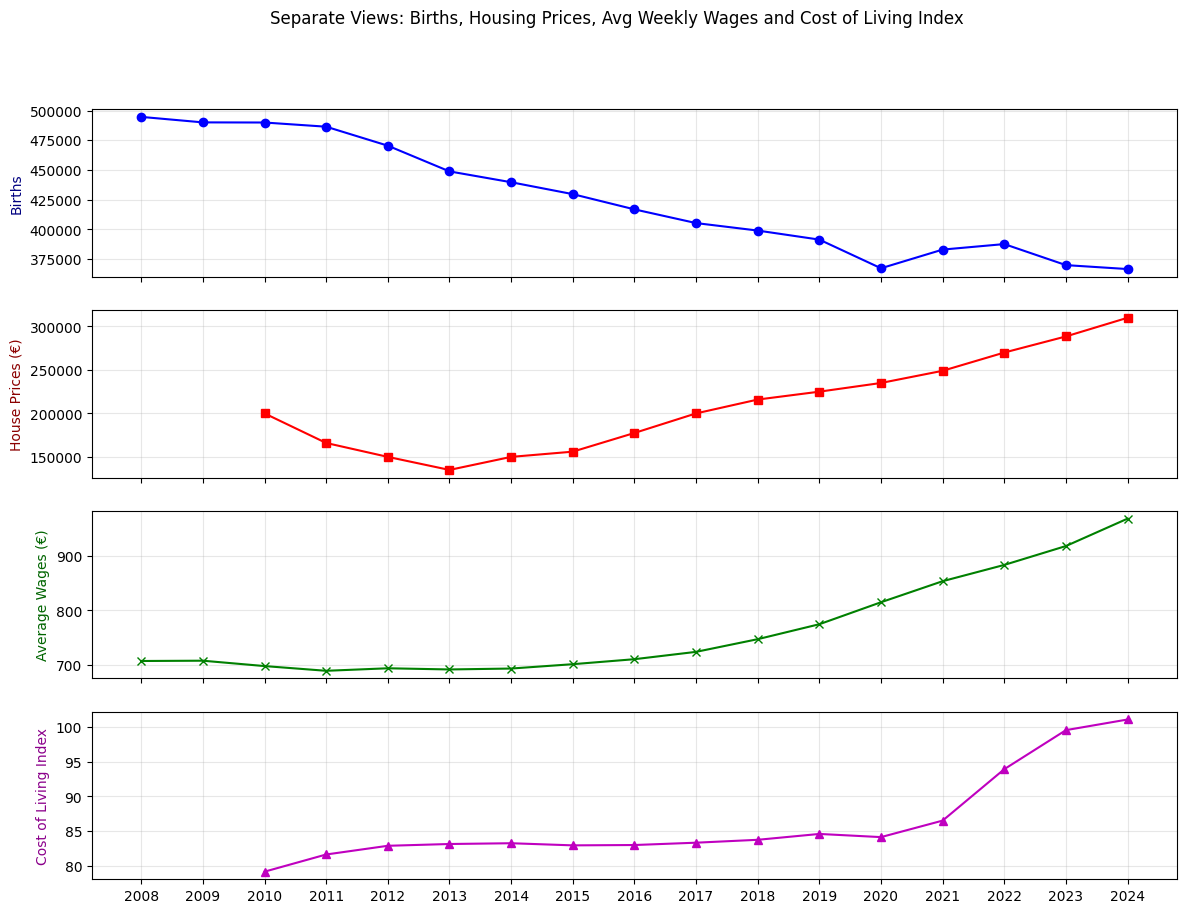

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

combined_data['births'] = pd.to_numeric(combined_data['births'])
combined_data['Median_Price'] = pd.to_numeric(combined_data['Median_Price'])
combined_data['Avg_Wage'] = pd.to_numeric(combined_data['Avg_Wage'])
combined_data['Cost_of_Living_Index'] = pd.to_numeric(combined_data['Cost_of_Living_Index'])

plt.figure(figsize=(14, 7))

fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

ax1.plot(combined_data['Year'], combined_data['births'], 'b-o')
ax1.set_ylabel('Births', color='navy')
ax1.grid(True, alpha=0.3)

ax2.plot(combined_data['Year'], combined_data['Median_Price'], 'r-s')
ax2.set_ylabel('House Prices (€)', color='darkred')
ax2.grid(True, alpha=0.3)

ax3.plot(combined_data['Year'], combined_data['Avg_Wage'], 'g-x')
ax3.set_ylabel('Average Wages (€)', color='darkgreen')
ax3.grid(True, alpha=0.3)

ax4.plot(combined_data['Year'], combined_data['Cost_of_Living_Index'], 'm-^')
ax4.set_ylabel('Cost of Living Index', color='darkmagenta')
ax4.grid(True, alpha=0.3)

plt.suptitle('Separate Views: Births, Housing Prices, Avg Weekly Wages and Cost of Living Index')
plt.show()

<Figure size 1400x700 with 0 Axes>

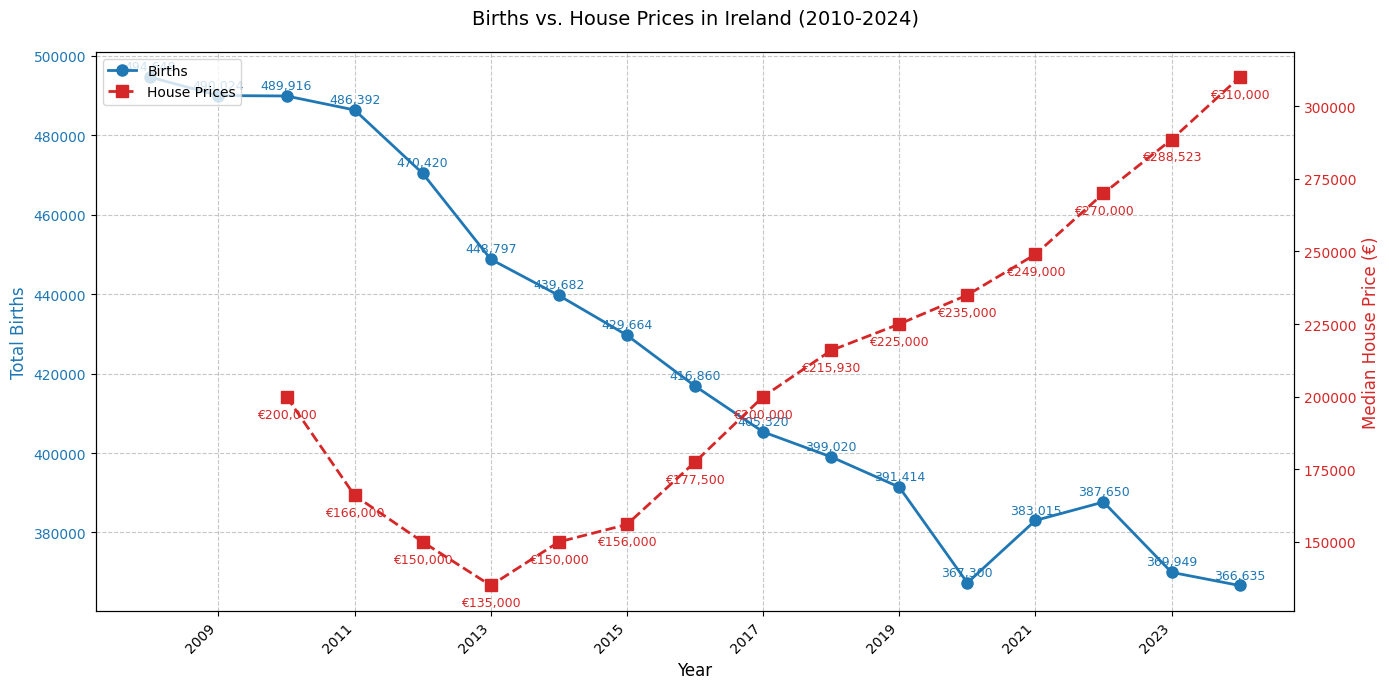

In [ ]:
plt.figure(figsize=(14, 7))
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Births', color=color, fontsize=12)
births_line = ax1.plot(combined_data['Year'],
                      combined_data['births'],
                      color=color,
                      marker='o',
                      linestyle='-',
                      linewidth=2,
                      markersize=8,
                      label='Births')

for year, births in zip(combined_data['Year'], combined_data['births']):
    ax1.annotate(f'{births:,.0f}',  # Format with commas
                xy=(year, births),
                xytext=(0, 5),  # Offset upward
                textcoords='offset points',
                ha='center',
                color=color,
                fontsize=9)

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(2010, 2025))
ax1.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Median House Price (€)', color=color, fontsize=12)
houses_line = ax2.plot(combined_data['Year'],
                      combined_data['Median_Price'],
                      color=color,
                      marker='s',
                      linestyle='--',
                      linewidth=2,
                      markersize=8,
                      label='House Prices')

for year, price in zip(combined_data['Year'], combined_data['Median_Price']):
    ax2.annotate(f'€{price:,.0f}',  # Euro symbol and commas
                xy=(year, price),
                xytext=(0, -15),  # Offset downward
                textcoords='offset points',
                ha='center',
                color=color,
                fontsize=9)

ax2.tick_params(axis='y', labelcolor=color)

lines = births_line + houses_line
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
plt.title('Births vs. House Prices in Ireland (2010-2024)', pad=20, fontsize=14)

plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

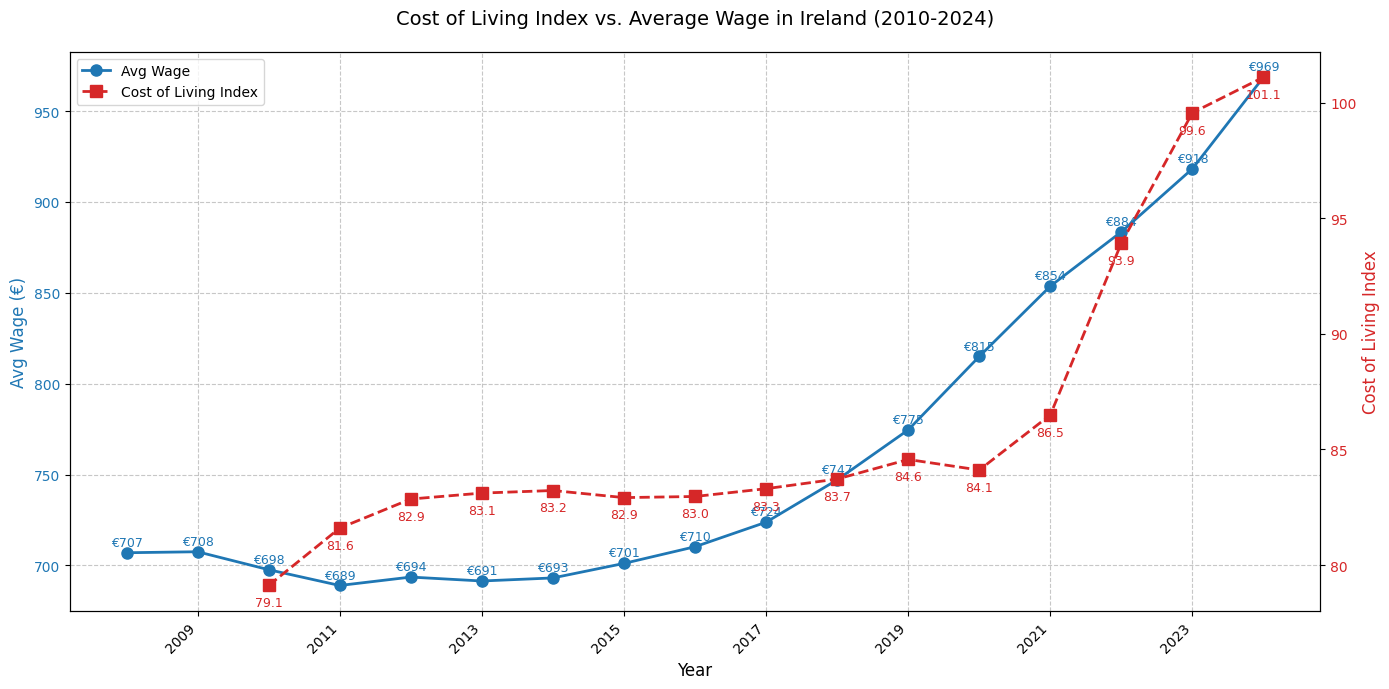

In [ ]:
plt.figure(figsize=(14, 7))
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Avg Wage (€)', color=color, fontsize=12)
wage_line = ax1.plot(combined_data['Year'],
                    combined_data['Avg_Wage'],
                    color=color,
                    marker='o',
                    linestyle='-',
                    linewidth=2,
                    markersize=8,
                    label='Avg Wage')

for year, wage in zip(combined_data['Year'], combined_data['Avg_Wage']):
    ax1.annotate(f'€{wage:,.0f}',
                xy=(year, wage),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center',
                color=color,
                fontsize=9,
    )
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(range(2010, 2025))
ax1.xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Cost of Living Index', color=color, fontsize=12)
col_line = ax2.plot(combined_data['Year'],
                   combined_data['Cost_of_Living_Index'],
                   color=color,
                   marker='s',
                   linestyle='--',
                   linewidth=2,
                   markersize=8,
                   label='Cost of Living Index')

for year, col in zip(combined_data['Year'], combined_data['Cost_of_Living_Index']):
    ax2.annotate(f'{col:.1f}',
                xy=(year, col),
                xytext=(0, -15),
                textcoords='offset points',
                ha='center',
                color=color,
                fontsize=9,
    )

ax2.tick_params(axis='y', labelcolor=color)

lines = wage_line + col_line
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
plt.title('Cost of Living Index vs. Average Wage in Ireland (2010-2024)', pad=20, fontsize=14)

plt.tight_layout()
plt.show()

##Exploratory Data Analysis##


Correlation coefficient (2010–2024): -0.78


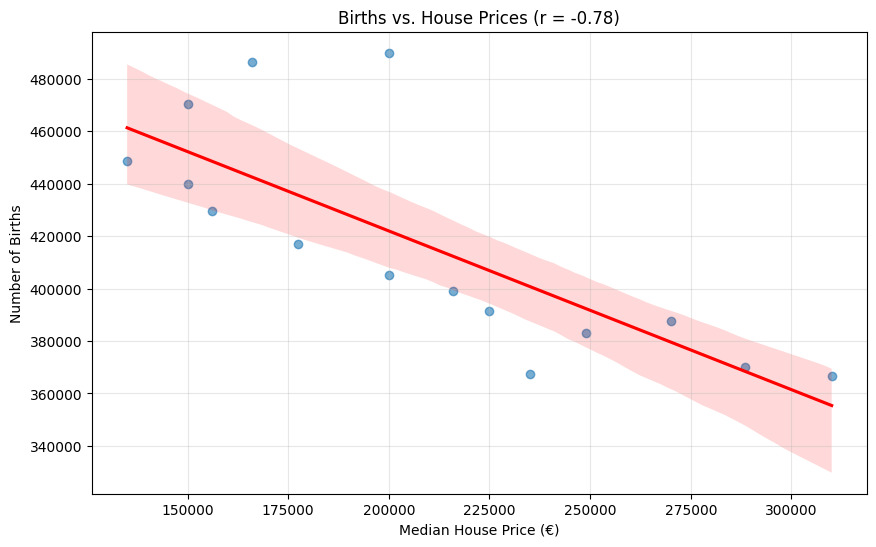

In [ ]:
import seaborn as sns

# Calculating correlation
combined_data['Year'] = combined_data['Year'].astype(int)
filtered_data = combined_data[(combined_data['Year'] >= 2010) & (combined_data['Year'] <= 2024)]
correlation = filtered_data['births'].corr(filtered_data['Median_Price'])
print(f"Correlation coefficient (2010–2024): {correlation:.2f}")

plt.figure(figsize=(10, 6))
sns.regplot(x='Median_Price', y='births', data=combined_data,
            scatter_kws={'alpha':0.6},
            line_kws={'color':'red'})
plt.title(f'Births vs. House Prices (r = {correlation:.2f})', fontsize=12)
plt.xlabel('Median House Price (€)', fontsize=10)
plt.ylabel('Number of Births', fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

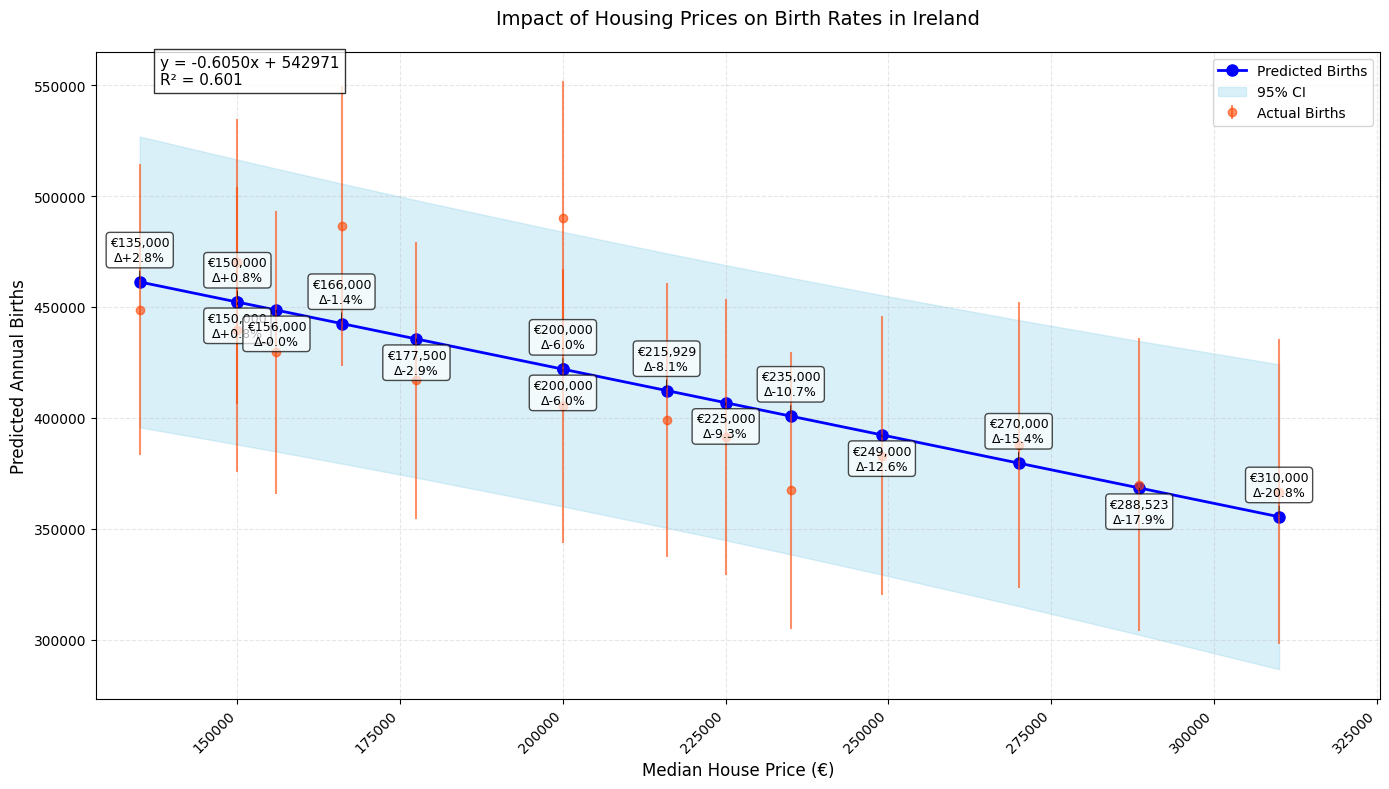

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

combined_data_clean = combined_data[['Median_Price', 'births']].replace([np.inf, -np.inf], np.nan).dropna()

x = combined_data_clean['Median_Price']
y = combined_data_clean['births']

x_const = sm.add_constant(x)
model = sm.OLS(y, x_const).fit()
predictions = model.predict(x_const)

prediction_results = model.get_prediction(x_const)
prediction_frame = prediction_results.summary_frame(alpha=0.05)
iv_l = prediction_frame['obs_ci_lower']
iv_u = prediction_frame['obs_ci_upper']

sorted_idx = np.argsort(x)
x_sorted = x.iloc[sorted_idx]
y_sorted = y.iloc[sorted_idx]
pred_sorted = predictions.iloc[sorted_idx]
iv_l_sorted = iv_l.iloc[sorted_idx]
iv_u_sorted = iv_u.iloc[sorted_idx]

plt.figure(figsize=(14, 8))

plt.plot(x_sorted, pred_sorted, label='Predicted Births', color='blue',
         marker='o', markersize=8, linewidth=2)
plt.fill_between(x_sorted, iv_l_sorted, iv_u_sorted, color='skyblue',
                 alpha=0.3, label='95% CI')
plt.errorbar(x_sorted, y_sorted, yerr=(iv_u_sorted - iv_l_sorted)/2,
             fmt='o', color='orangered', alpha=0.6, label='Actual Births')

baseline = y_sorted.iloc[0]

for i, (xp, yp) in enumerate(zip(x_sorted, pred_sorted)):
    delta = yp - baseline
    pct = (delta / baseline) * 100

    y_offset = 15 if i % 2 == 0 else -25
    ha = 'center'

    plt.annotate(
        f"€{int(xp):,}\nΔ{pct:+.1f}%",
        xy=(xp, yp),
        xytext=(0, y_offset),
        textcoords="offset points",
        ha=ha,
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7),
        arrowprops=dict(arrowstyle='-', lw=0.5)
    )

slope = model.params['Median_Price']
intercept = model.params['const']
equation_text = f"y = {slope:.4f}x + {intercept:.0f}\nR² = {model.rsquared:.3f}"
plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes,
         fontsize=11, bbox=dict(facecolor='white', alpha=0.8))

plt.title("Impact of Housing Prices on Birth Rates in Ireland", pad=20, fontsize=14)
plt.xlabel("Median House Price (€)", fontsize=12)
plt.ylabel("Predicted Annual Births", fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.3)

plt.xlim(x_sorted.min()*0.95, x_sorted.max()*1.05)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig("housing_birth_impact_clean.png", dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-40-b4736114d133>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = combined_data.groupby('Price_Bin').agg(


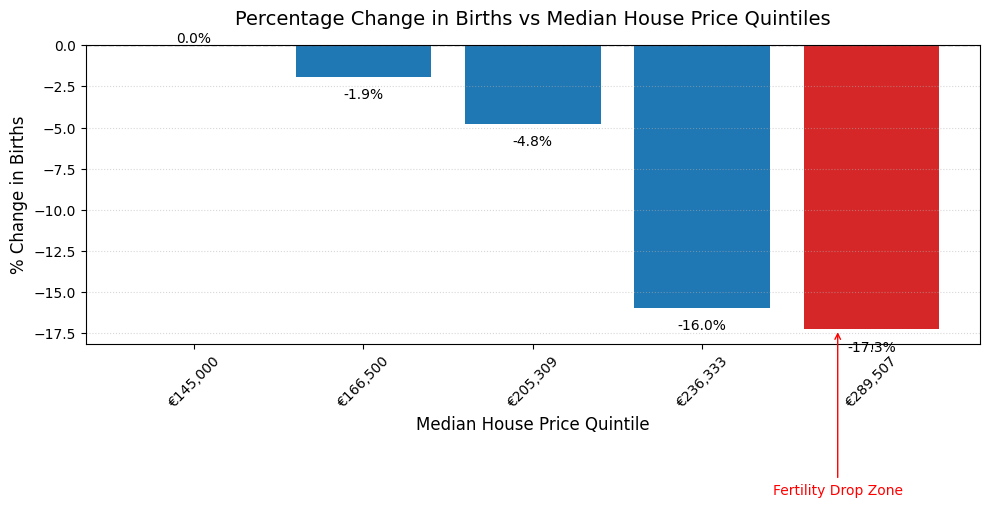

In [ ]:
combined_data['Price_Bin'] = pd.qcut(combined_data['Median_Price'], 5)

summary = combined_data.groupby('Price_Bin').agg(
    mean_births=('births', 'mean'),
    mean_price=('Median_Price', 'mean')
).reset_index()

baseline = summary['mean_births'].iloc[0]
summary['birth_change_pct'] = (summary['mean_births'] - baseline) / baseline * 100

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(summary)), summary['birth_change_pct'],
               color=['#2ca02c'] + ['#1f77b4']*3 + ['#d62728'])

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + np.sign(bar.get_height()) * 1.5,
             f"{summary['birth_change_pct'].iloc[i]:.1f}%",
             ha='center', va='bottom', fontsize=10)

plt.title("Percentage Change in Births vs Median House Price Quintiles", fontsize=14, pad=15)
plt.xlabel("Median House Price Quintile", fontsize=12)
plt.ylabel("% Change in Births", fontsize=12)
plt.xticks(range(len(summary)), [f"€{int(p):,}" for p in summary['mean_price']], rotation=45)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(axis='y', linestyle=':', alpha=0.5)

plt.annotate("Fertility Drop Zone", (3.8, summary['birth_change_pct'].iloc[-1]),
             xytext=(3.8, summary['birth_change_pct'].iloc[-1] - 10),
             textcoords='data', ha='center',
             arrowprops=dict(arrowstyle="->", color='red'),
             fontsize=10, color='red')

plt.tight_layout()
plt.savefig("birth_percentage_changes_fixed.png", dpi=300)
plt.show()

##Bayesian Modelling##

In [ ]:
combined_data['Housing_Burden'] = combined_data['Median_Price'] / (combined_data['Avg_Wage'] * 52)

print("=== VALIDATED DATA RANGES ===")
print("Realistic Housing Burden range:",
      round(combined_data['Housing_Burden'].min(), 1), "-",
      round(combined_data['Housing_Burden'].max(), 1), "years")

=== VALIDATED DATA RANGES ===
Realistic Housing Burden range: 3.8 - 6.2 years


In [ ]:
births_threshold = combined_data['births'].quantile(0.3)
housing_threshold = combined_data['Housing_Burden'].quantile(0.7)
cost_threshold = combined_data['Cost_of_Living_Index'].quantile(0.7)

combined_data['Low_Fertility'] = combined_data['births'] <= births_threshold
combined_data['High_Housing'] = combined_data['Housing_Burden'] >= housing_threshold
combined_data['High_Cost'] = combined_data['Cost_of_Living_Index'] >= cost_threshold

print("\n=== BURDEN FLAG COUNTS ===")
print("High Housing Burden cases:", combined_data['High_Housing'].sum())
print("High Cost Burden cases:", combined_data['High_Cost'].sum())
print("Both burdens:", combined_data[(combined_data['High_Housing']) & (combined_data['High_Cost'])].shape[0])


=== BURDEN FLAG COUNTS ===
High Housing Burden cases: 5
High Cost Burden cases: 5
Both burdens: 5


In [ ]:
pre_crisis = combined_data[combined_data['Year'].astype(int).between(2010, 2013)]
post_crisis = combined_data[combined_data['Year'].astype(int).between(2014, 2023)]

prior = max(pre_crisis['Low_Fertility'].mean(), 0.2)

n_both_and_low = len(post_crisis[
    (post_crisis['Low_Fertility']) &
    (post_crisis['High_Housing']) &
    (post_crisis['High_Cost'])
])
n_low_fertility = post_crisis['Low_Fertility'].sum()
likelihood = n_both_and_low / n_low_fertility if n_low_fertility != 0 else 0

n_both_burdens = len(post_crisis[
    (post_crisis['High_Housing']) &
    (post_crisis['High_Cost'])
])
evidence = n_both_burdens / len(post_crisis) if len(post_crisis) != 0 else 0

posterior = (likelihood * prior) / evidence if evidence != 0 else 0


=== BAYESIAN RESULTS ===
Prior: 0.20
Likelihood: 0.75 (3/4)
Evidence: 0.40 (4/10)
Posterior: 0.38


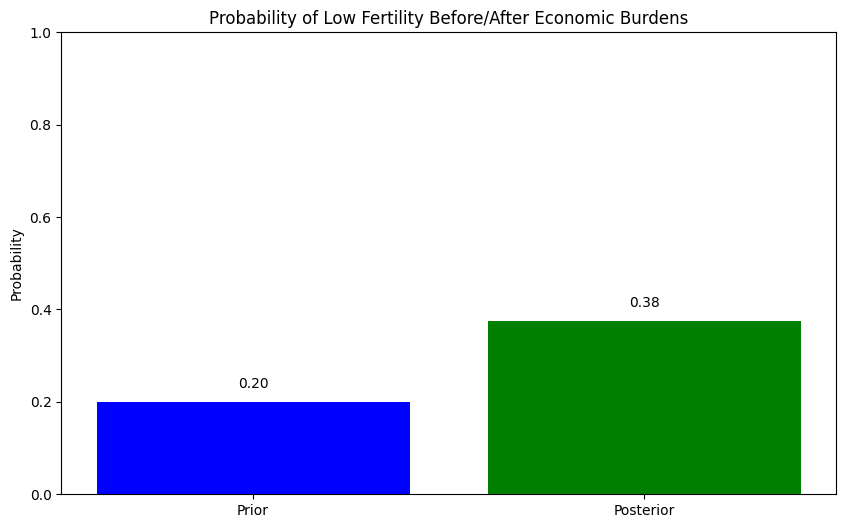

In [ ]:
print("\n=== BAYESIAN RESULTS ===")
print(f"Prior: {prior:.2f}")
print(f"Likelihood: {likelihood:.2f} ({n_both_and_low}/{n_low_fertility})")
print(f"Evidence: {evidence:.2f} ({n_both_burdens}/{len(post_crisis)})")
print(f"Posterior: {posterior:.2f}")

plt.figure(figsize=(10, 6))
results = {
    'Prior': prior,
    'Posterior': posterior
}
plt.bar(results.keys(), results.values(), color=['blue', 'green'])
plt.ylim(0, 1)
plt.title('Probability of Low Fertility Before/After Economic Burdens')
plt.ylabel('Probability')
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.03, f"{v:.2f}", ha='center')
plt.show()

Output()

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta_cost'}>,
       <Axes: title={'center': 'beta_housing'}>], dtype=object)

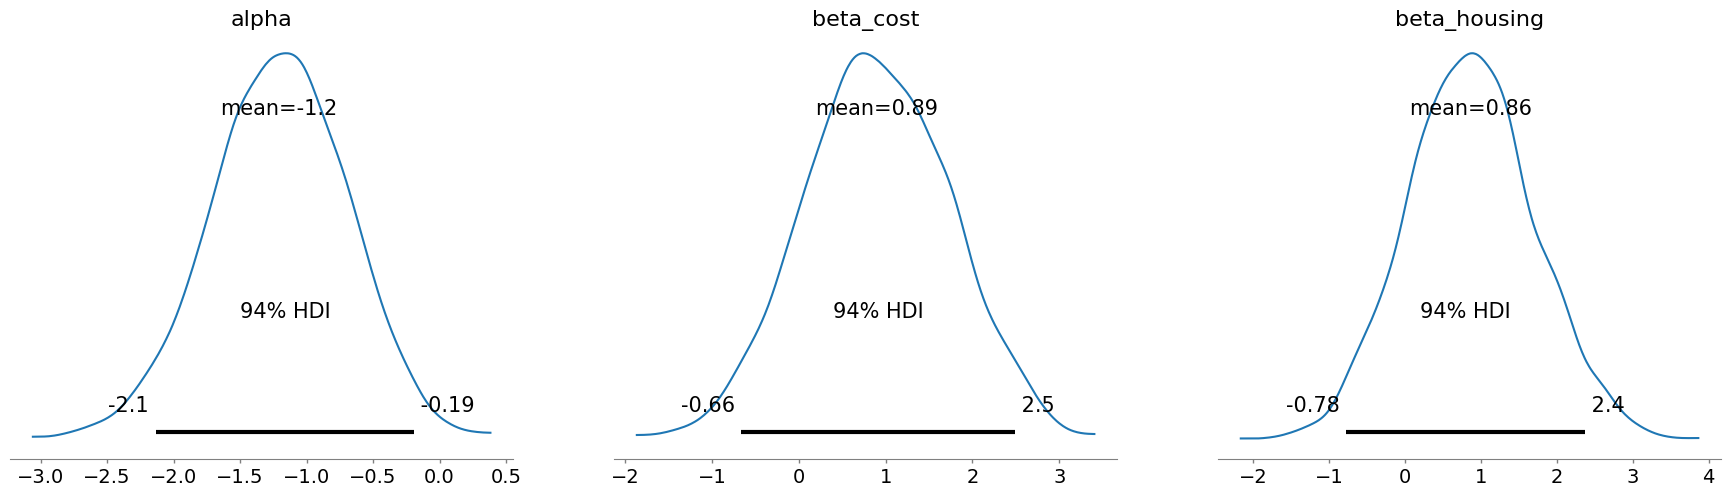

In [ ]:
import pymc as pm
import arviz as az

with pm.Model() as fertility_model:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta_housing = pm.Normal("beta_housing", mu=0, sigma=1)
    beta_cost = pm.Normal("beta_cost", mu=0, sigma=1)


    p = pm.math.sigmoid(
        alpha +
        beta_housing * combined_data["High_Housing"].astype(int) +
        beta_cost * combined_data["High_Cost"].astype(int)
    )

    fertility_obs = pm.Bernoulli("fertility_obs", p=p, observed=combined_data["Low_Fertility"].astype(int))

    trace = pm.sample(2000, tune=1000, target_accept=0.95)

az.summary(trace)
az.plot_posterior(trace)
